In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory

In [690]:
from scipy.stats import erlang, norm
from scipy.special import erf
import math
def create_exp_dist(lamb):
    def exp_dist(x):
        return lamb*np.exp(-lamb*x)
    return exp_dist

def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
#         ret = np.exp(-lamb*x)*lamb
#         for i in range(1, k):
#             ret = ret*(x*lamb)/i
#         return ret#np.exp(-lamb*x)*((x*lamb)**k)/x#(x*math.factorial(k-1))
    return Erlang_dist

def create_normal_dist(mean, std):
    def normal_dist(x):
        #return np.exp(-((x-mean)**2)/(2*std*std))/np.sqrt(2*np.pi*std*std)
        return norm.pdf(x, loc=mean, scale=std)
    return normal_dist

def alpha(c, dist_func=None):
    assert dist_func != None
    return integrate.quad(lambda x: (1-(x/c))*dist_func(x),
                          0, 
                          c)[0]

def alpha_erlang(c, lamb, k):    
    return ((erlang.pdf(c, k, scale=1/lamb)/lamb) 
            + ((1-k/(c*lamb)))*erlang.cdf(c, k, scale=1/lamb))

def alpha_clt(c, mean, std, k):
    mean_c = k*mean
    std_c = np.sqrt(k)*std
    def q2(r):
        sqrt = np.sqrt
        pi = np.pi
        exp = np.exp    
        return ( .5*(1-(mean_c/c))*erf((r-mean_c)/sqrt(2*std_c*std_c))
                + (std_c/sqrt(2*pi*c*c))*exp(-(r-mean_c)**2/(2*std_c*std_c)))
    
    return q2(c)-q2(0)

def alpha_clt_old(c, mean, std, k):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp
    
    a1 = .5 - (k*mean/(2*c))
    a2 = sqrt(k*std*std/(2*pi*c*c))
    a3 = (c - k*mean)/sqrt(2*k*std*std)
    a4 = (k*mean)/sqrt(2*k*std*std)
    return (a1*(erf(a3) + erf(a4))
           +a2*(exp(-a3*a3) - exp(-a4*a4)))

def alpha_clt_folded_Gaussian(c, std, k):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp
    
    a1 = .5-((k*std)/sqrt(2*pi*c*c)) 
    a2 = sqrt(k*(pi-2)*std*std/(2*pi*pi*c*c))
    a3 = (c-k*sqrt(2/pi)*std)/sqrt(2*k*(1-(2/pi))*std*std)
    a4 = sqrt(k/(pi-2))
    return (a1*(erf(a3) + erf(a4))
           +a2*(exp(-a3*a3) - exp(-a4*a4)))

def alpha_integrated(c, dist_func=None):
    assert dist_func != None
    return integrate.quad(lambda x: (1-(x/c))*dist_func(x),
                          -np.inf, 
                          c)[0]

def gamma(c, dist_func=None):
    
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    
    def g(r):
        return (.5 
                + (2*r/(3*c*pi)) 
                - (r/(c*pi))*power(1- (c/r)**2, 1/2)
                + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
                - (arcsin(c/r)/pi))
    
    in1, err1 = integrate.quad(lambda r: r*dist_func(r),
                          0, 
                          c, epsabs=1e-12,limit=1000)
    in2, err2 = integrate.quad(lambda r: g(r)*dist_func(r),
                                              c, 
                                              np.inf, epsabs=1e-12, limit=1000)
#     if err2 == 0:
#         print(n_times_mean)
#         in2 = g(n_times_mean)
    return (2/(3*c*pi))*in1 + in2

def gamma_with_laplace(c, n, mean, dist_func=None):
    
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    
    def g(r):
        return (.5 
                + (2*r/(3*c*pi)) 
                - (r/(c*pi))*power(1- (c/r)**2, 1/2)
                + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
                - (arcsin(c/r)/pi))
    
    in1, err1 = integrate.quad(lambda r: r*dist_func(r),
                          0, 
                          c, epsrel = 1e-13, epsabs = 0,limit=10000)
    in2, err2 = integrate.quad(lambda r: g(r)*dist_func(r),
                                              c, 
                                              np.inf, epsrel = 1e-13, epsabs = 0, limit=10000)
    if err2 == 0 and n*mean >= c and n > 100:  
        print(f"Warning- c:{c}, n:{n}, mean:{mean}")
        in2 = g(n*mean)
    return (2/(3*c*pi))*in1 + in2



In [65]:
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 2
lambs = np.array([.1*c, .5*c, c, c*10, c*50,  1000*c])

dists = np.array([[create_Erlang_dist(lamb, n-1) 
                             for n in ns]
                             for lamb in lambs ])

alphas = np.array([[alpha_integrated(c, dist) 
                     for dist, n in zip(dists[i, :], ns)]
                      for i in range(dists.shape[0])])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

alphas2 = np.array([[alpha_erlang(c, lamb, n-1) 
                             for n in ns]
                             for lamb in lambs ])
alphas2_n = np.array([[alpha**n
                      for alpha, n in zip(alphas2[i, :], ns)]
                      for i in range(alphas2.shape[0])
                  ])

alphasc = np.array([[alpha_clt(c, 1/lamb, 1/lamb, n-1) 
                             for n in ns]
                             for lamb in lambs])

alphasc_n = np.array([[alpha**n
                      for alpha, n in zip(alphasc[i, :], ns)]
                      for i in range(alphasc.shape[0])
                  ])

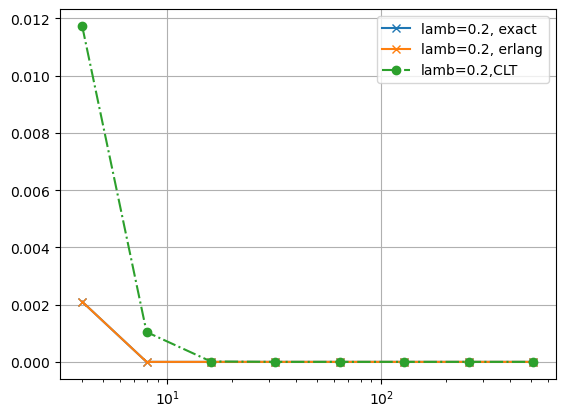

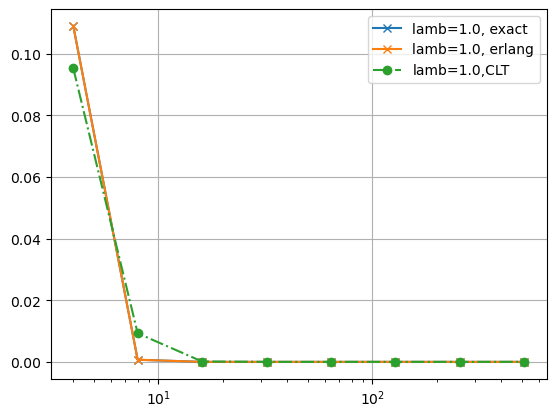

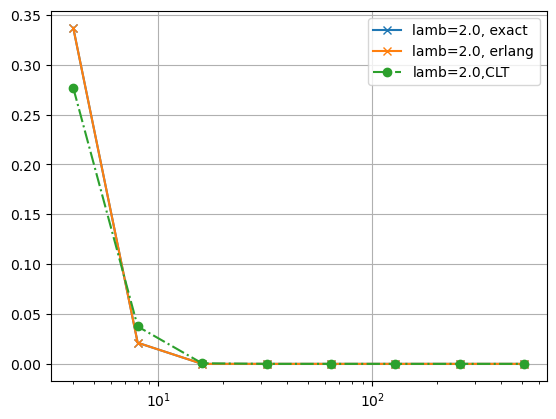

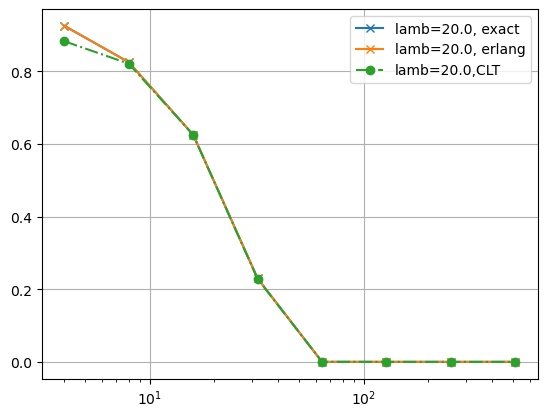

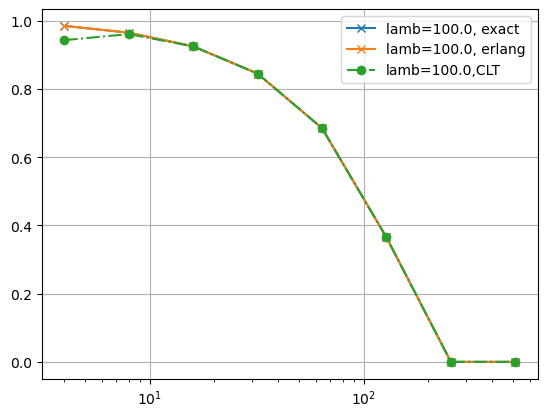

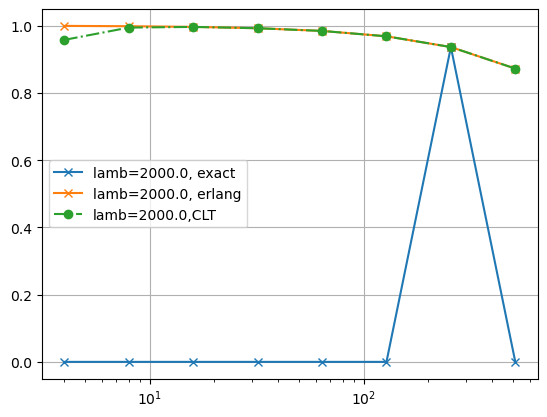

In [66]:
for k in range(alphas.shape[0]):
    plt.plot(ns, alphas[k,:],'-x', label=f"lamb={lambs[k]}, exact")
    plt.plot(ns, alphas2[k,:],'-x', label=f"lamb={lambs[k]}, erlang")
    plt.plot(ns, alphasc[k,:], '-.o', label=f"lamb={lambs[k]},CLT")
    plt.grid();plt.xscale('log');plt.legend();plt.show()

In [75]:
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 1
stds = np.array([ 0.01, 0.1, 1])

dists = np.array([[create_clt_zero_mean_k_folded_normal_dist(std, n-1) 
                             for n in ns]
                             for std in stds])

alphas = np.array([[alpha_integrated(c, dist) 
                     for dist, n in zip(dists[i, :], ns)]
                      for i in range(dists.shape[0])])

alphasc = np.array([[alpha_clt(c, std*np.sqrt(2/np.pi), std, n-1) 
                             for n in ns]
                             for std in stds])


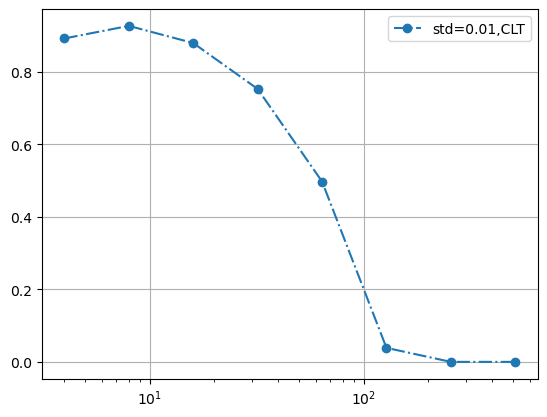

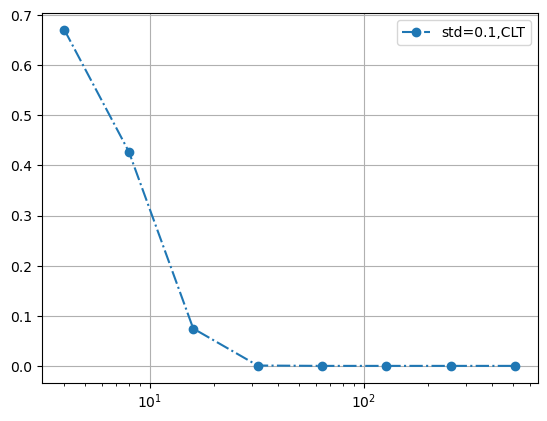

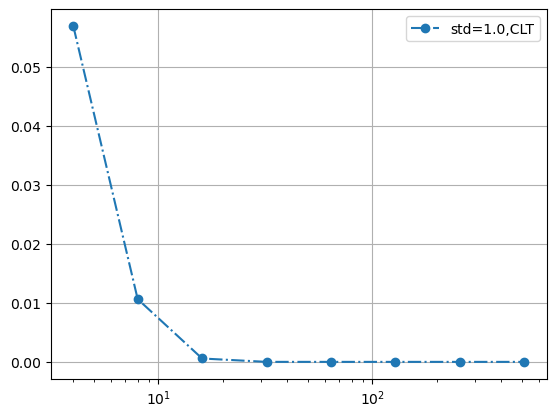

In [89]:
for k in range(alphas.shape[0]):
    #plt.plot(ns, alphas[k,:],'-x', label=f"std={stds[k]}, exact")
    plt.plot(ns, alphasc[k,:], '-.o', label=f"std={stds[k]},CLT")
    plt.grid();plt.xscale('log');plt.legend();plt.show()

In [442]:
sqrt = np.sqrt
pi = np.pi
arcsin = np.arcsin

def g(r, c):
    return (r/(3*c*pi))*sqrt(1 - (c/r)**2)*(2+(c/r)**2) + arcsin(c/r)/pi

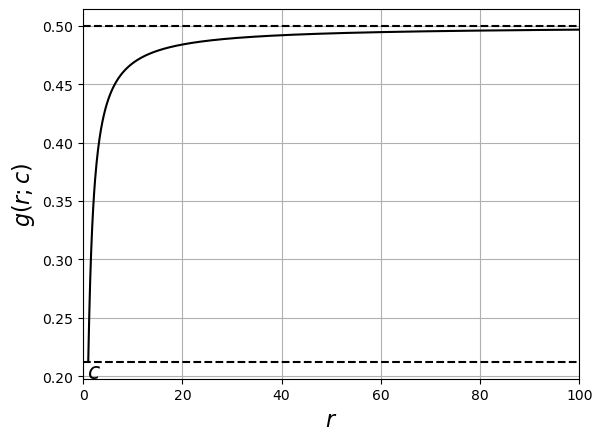

In [665]:
c = 1
rs = np.linspace(c,100, 1000)


plt.plot(rs, .5+(2*rs/(3*np.pi*c))-g(rs, c), '-', color='black')
plt.hlines(.5, 0, rs[-1], linestyles='--', color='black')
plt.hlines(2/(3*np.pi), 0, rs[-1], linestyles='--', color='black')
#plt.text(-7, 2/(3*np.pi), r"$\frac{2}{3 \pi}$", fontsize=16)
plt.text(c*.85, 1.87/(3*np.pi), r"$c$", fontsize=16)
#plt.text(-7, .5, r"$\frac{1}{2}$", fontsize=16)
plt.grid();plt.xlim(0, rs[-1])
plt.xlabel(r"$r$", fontsize=16);plt.ylabel(r"$g(r;c)$", fontsize=16);plt.show()

In [388]:
def n_star(alpha, gamma):
    b = 1 - gamma*(1-alpha)
    log = np.log
    return (log(-log(b)) - log(-log(alpha)))/(log(alpha) - log(b))

In [92]:
import math
def psn3(c, lamb, k):
        
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():
        def func(r):
            ret = second_int(r) * lamb  * np.exp(-lamb*r)
            for i in range(1, k):
                ret = ret*lamb*r/i
            return ret
            #return second_int(r) * (lamb**k) * (r**(k-1)) * np.exp(-lamb*r)/math.factorial(k-1)
        return integrate.quad(func,
                              c, np.inf)[0]
    return (2*k/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()

Text(0, 0.5, '$(1 - \\gamma(1-\\alpha)^n - \\alpha^2$ bounds')

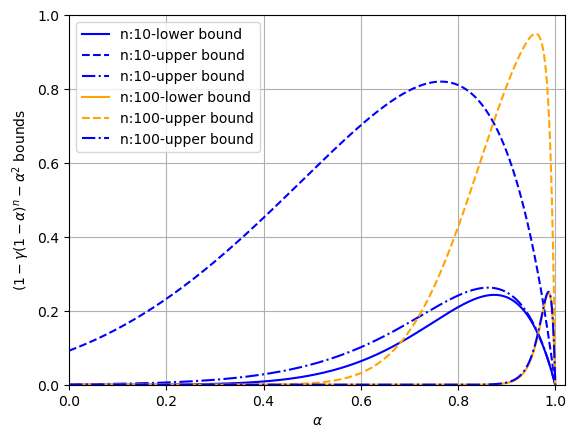

In [131]:
alps = np.linspace(0,1, 1000)
a1 = 1 - (1*(1-alps)/2) - ((2/(3*np.pi))*(1-alps)**2)
a2 = 1 - (2/(3*np.pi))*(1-alps)**2
a3 = 1 - (1-alps)/2

e = 10
plt.plot(alps, a1**e - alps**e, color='blue', label=f"n:{e}-lower bound")
plt.plot(alps, a2**e - alps**e, '--', color='blue', label=f"n:{e}-upper bound");
plt.plot(alps, a3**e - alps**e, '-.', color='blue', label=f"n:{e}-upper bound");

e = 100
plt.plot(alps, a1**e - alps**e, color='orange', label=f"n:{e}-lower bound")
plt.plot(alps, a2**e - alps**e, '--', color='orange', label=f"n:{e}-upper bound");
plt.plot(alps, a3**e - alps**e, '-.', color='blue', label=f"n:{e}-upper bound");

plt.grid();plt.ylim([0,1]);plt.xlim([0,1.02]);plt.legend()
plt.xlabel(r"$\alpha$");plt.ylabel(r"$(1 - \gamma(1-\alpha)^n - \alpha^2$ bounds")

In [560]:
repeats = 5
res5 = np.load("P_I_P_S_expo_no_scaling.npy")
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 1
lambs = np.array([ c*10, c*50,  1000*c])

stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
stats_inc_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res5[index][1]
            stats_inc_stable[j, k, t ] =   res5[index][2]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)
mean_inc_stable = np.mean(stats_inc_stable, axis=2)
std_inc_stable = np.std(stats_inc_stable, axis=2)



alphas = np.array([[alpha_erlang(c, lamb, n-1) 
                             for n in ns]
                             for lamb in lambs ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

# alphas_erlang  = np.array([[alpha_erlang(c, lamb, n-1) 
#                             for n in ns]
#                             for lamb in lambs ])

gammas = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns] for lamb in lambs])
dists = np.array([[create_normal_dist((n-1)/(lamb*np.sqrt(n)), np.sqrt(n-1)/(lamb*np.sqrt(n))) 
                     for n in ns]
                     for lamb in lambs ])
gammas2 = np.array([[gamma(c, dist) 
                     for dist, n in zip(dists[i, :], ns)]
                      for i in range(dists.shape[0])])

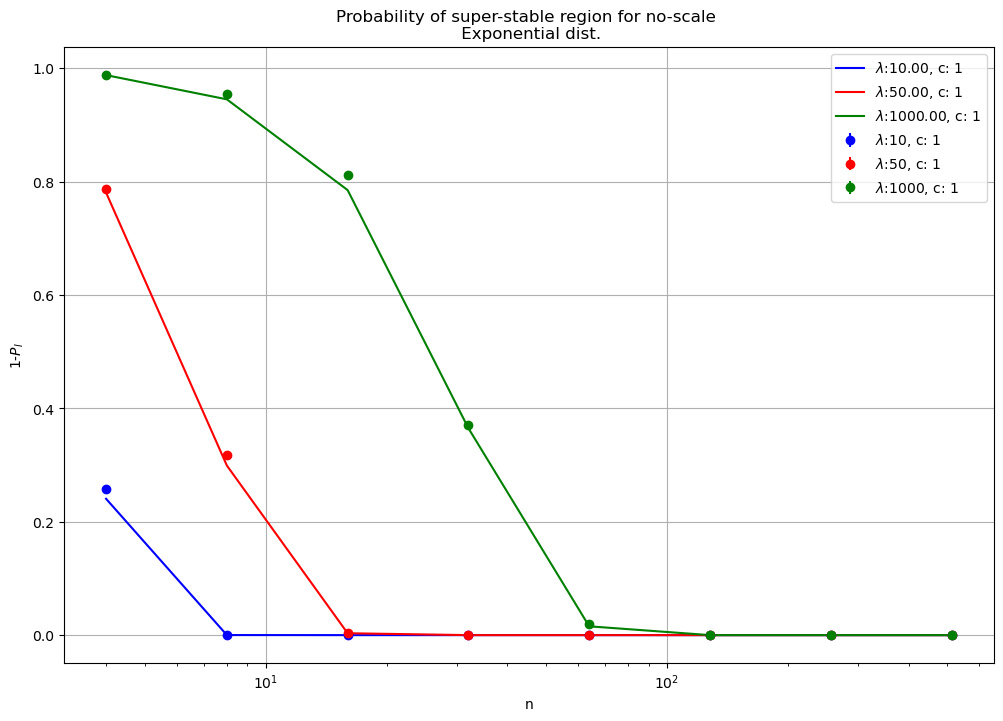

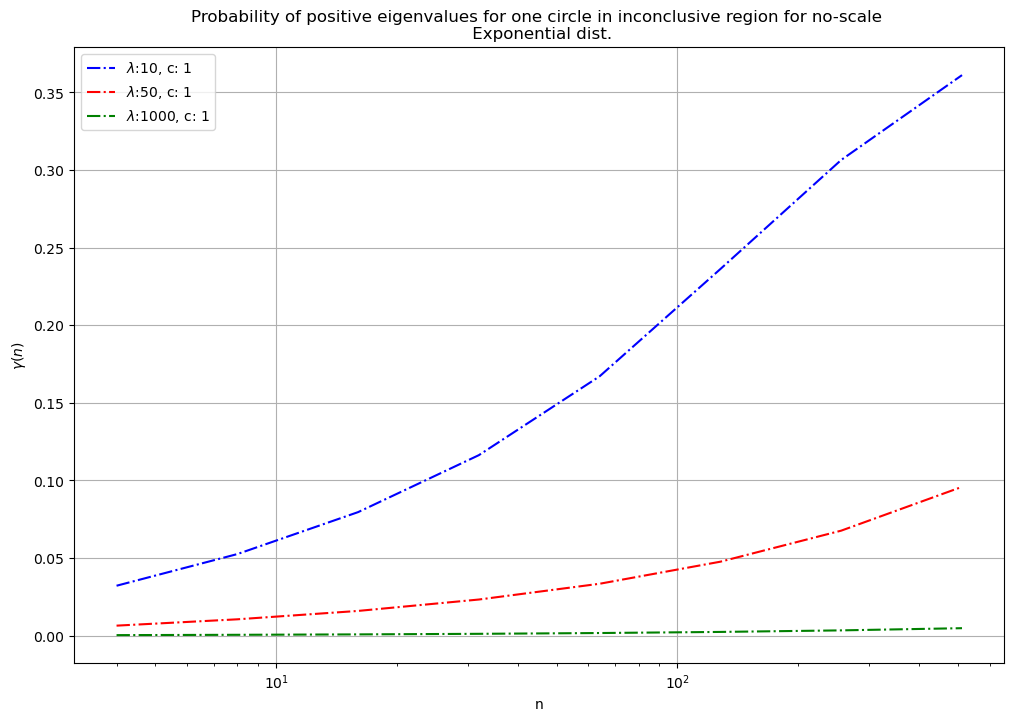

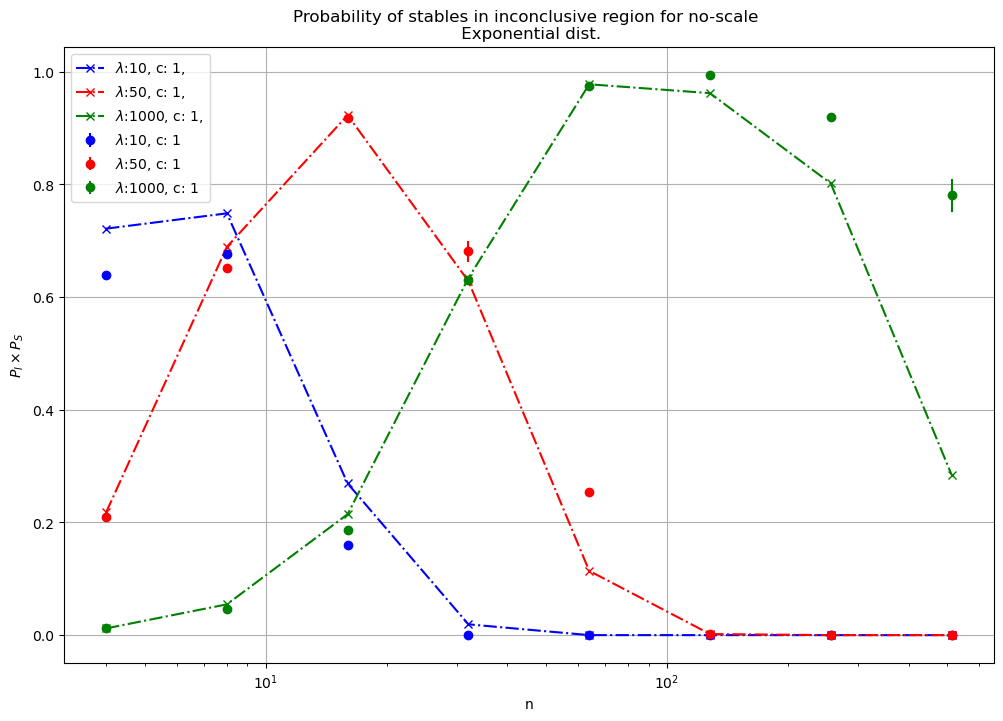

In [561]:
plt.figure(figsize=(12,8))
colors = ['blue', 'red', 'green']
for k,lamb in enumerate(lambs):
    plt.plot(ns,
             alphas_n[k, :], 
             '-',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c:2.0f}")        
    
    plt.errorbar(ns, mean_super_stable[:, k],
                 yerr=std_super_stable[:, k], 
                 fmt="o",
                 c=colors[k%3],
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title("Probability of super-stable region for no-scale \n Exponential dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(12,8))

for k,lamb in enumerate(lambs):    
    
    plt.plot(ns,
             gammas2[k, :], 
             '-.',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}" ) 

plt.xlabel("n");plt.ylabel(r"$\gamma(n)$");plt.title("Probability of positive eigenvalues for one circle in inconclusive region for no-scale \n Exponential dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(12,8))

for k,lamb in enumerate(lambs):
    
    plt.errorbar(ns, mean_inc_stable[:, k],
                 yerr=std_inc_stable[:, k],
                 fmt="o",
                 c=colors[k%3],
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    
    
    plt.plot(ns,
             (1 - gammas2[k, :]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, 
             '-.x',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )
    
    #plt.vlines(n_star(alphas[k,0], gammas[k,0]), 0, 1, colors=colors[k%3])
    
#     plt.plot(ns,
#              (1 - gammas[k, 0]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-',
#              label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )

plt.xlabel("n");plt.ylabel(r"$P_I \times P_S$");plt.title("Probability of stables in inconclusive region for no-scale \n Exponential dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

In [135]:
from scipy.stats import norm
from scipy.special import erf
import math
def create_normal_dist(mean, std):
    def normal_dist(x):
        return np.exp(-((x-mean)**2)/(2*std*std))/np.sqrt(2*np.pi*std*std)
        #return norm.pdf(x, loc=mean, scale=std)
    return normal_dist

def create_folded_normal_dist(mean, std):
    def folded_normal_dist(x):
        return (np.sqrt(2/(np.pi*std*std))*np.exp(-(x**2+mean**2)/(2*std*std))
                *np.cosh(x*mean/(std*std)))
        #return norm.pdf(x, loc=mean, scale=std)
    return folded_normal_dist

def create_zero_mean_k_folded_normal_dist(std, k):
    def zero_mean_k_folded_normal_dist(x):
        sqrt = np.sqrt
        exp = np.exp
        power = np.power
        pi = np.pi
        return (sqrt(2*k/(pi*std*std))*exp(-x*x/(2*k*std*std))
                *(power(erf(x/(sqrt(2*k)*std)),k-1)))
    return zero_mean_k_folded_normal_dist


def create_clt_zero_mean_k_folded_normal_dist(std, k):
    a1 = np.sqrt(2/np.pi)
    a2 = np.sqrt(1- (2/np.pi))
    def clt_zero_mean_k_folded_normal_dist(x):
        return norm.pdf(x, loc=a1*k*std, scale=a2*k*std)
    return clt_zero_mean_k_folded_normal_dist

import math
def psn4(c, std, k):
        
    nor = create_zero_mean_k_folded_normal_dist(std, k)
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():        
        return integrate.quad(lambda r: second_int(r)*nor(r),
                              c, np.inf)[0]
    
    def mean():
        return integrate.quad(lambda r: r*nor(r),
                              0, np.inf)[0]
    return (2*mean()/(3*np.pi*c)) + (1/(np.pi))*partial_E()

In [136]:
k=4
sigma =1
dist = create_clt_zero_mean_k_folded_normal_dist(sigma, k)
   
aaa = np.zeros(k+1)
L = 10000
for i in range(L):
    m = np.random.normal(0,sigma, ((k+1, k+1)))
    aaa += np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)#/k
    
    
np.mean(aaa/L),np.std(aaa/L), integrate.quad(lambda r: r*dist(r),
                              -np.inf, np.inf)[0], integrate.quad(lambda r: dist(r),
                              -np.inf, np.inf)[0]

(3.2007920928391025, 0.013224606164207725, 3.1915382432114625, 1.0)

In [562]:
repeats = 5
res6 = np.load("P_I_P_S_normal_no_scaling.npy")
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 1
stds = np.array([ 0.01, 0.1, 1])

stats_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0], repeats))
mean_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
std_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
stats_inc_stable_normal = np.zeros((ns.shape[0], stds.shape[0], repeats))
mean_inc_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
std_inc_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
for j,n in enumerate(ns):
    for k,std in enumerate(stds):
        for t in range(repeats):
            index = j*stds.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal[j, k, t ] =   res6[index][1]
            stats_inc_stable_normal[j, k, t ] =   res6[index][2]
            
mean_super_stable_normal = np.mean(stats_super_stable_normal, axis=2)
std_super_stable_normal = np.std(stats_super_stable_normal, axis=2)
mean_inc_stable_normal = np.mean(stats_inc_stable_normal, axis=2)
std_inc_stable_normal = np.std(stats_inc_stable_normal, axis=2)



alphas = np.array([[alpha_clt(c, std*np.sqrt(2/np.pi), std, n-1) 
                             for n in ns]
                             for std in stds])

alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])
# dists = np.array([[create_clt_zero_mean_k_folded_normal_dist(std, n-1)
#                    for n in  ns]
#                   for std in stds])
# alphas = np.array([[alpha_clt(c, dist) 
#                     for dist in dists[i, :]]
#                     for i in range(dists.shape[0])
#                   ])
# alphas_n = np.array([[alpha**n
#                       for alpha, n in zip(alphas[i, :], ns)]
#                       for i in range(alphas.shape[0])
#                   ])


gammas = np.array([[psn4(c, std , n) for n in ns] for std in stds] )

dists = np.array([[create_normal_dist((n-1)*std*np.sqrt(2/np.pi), 
                                      np.sqrt(n-1)*std*np.sqrt(1-(2/np.pi))) 
                     for n in ns]
                     for std in stds])
gammas2 = np.array([[gamma_with_laplace(c,(n-1),(n-1)*stds[i]*np.sqrt(2/np.pi) ,dist) 
                     for dist, n in zip(dists[i, :], ns)]
                      for i in range(dists.shape[0])])

Warning- c:1, n:255, mean:203.4605630047307
Warning- c:1, n:511, mean:407.71901057026423


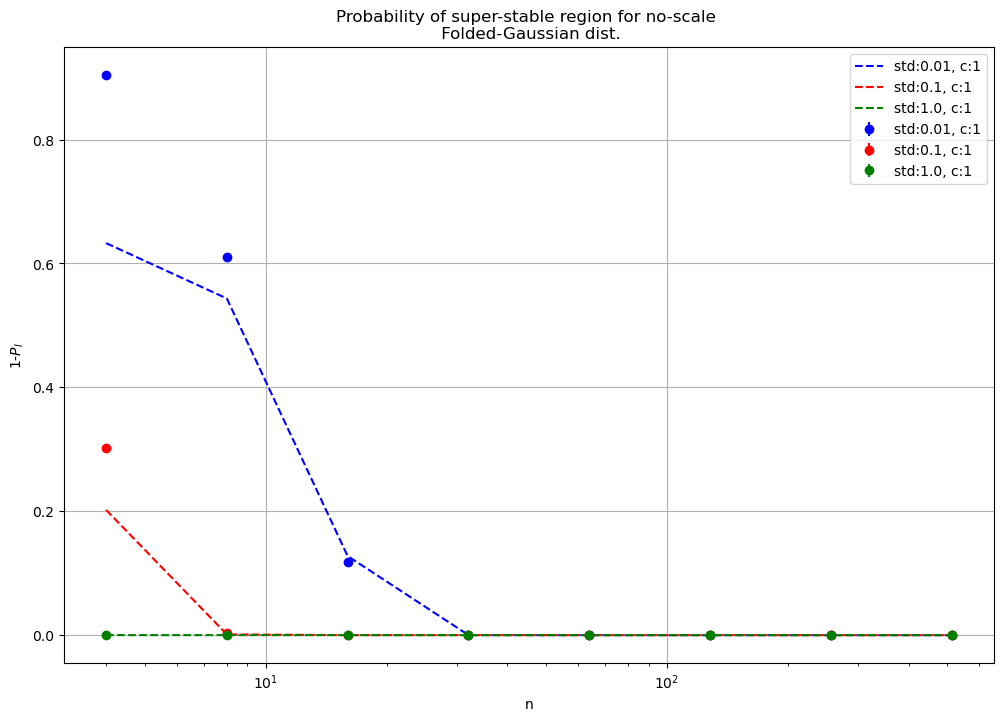

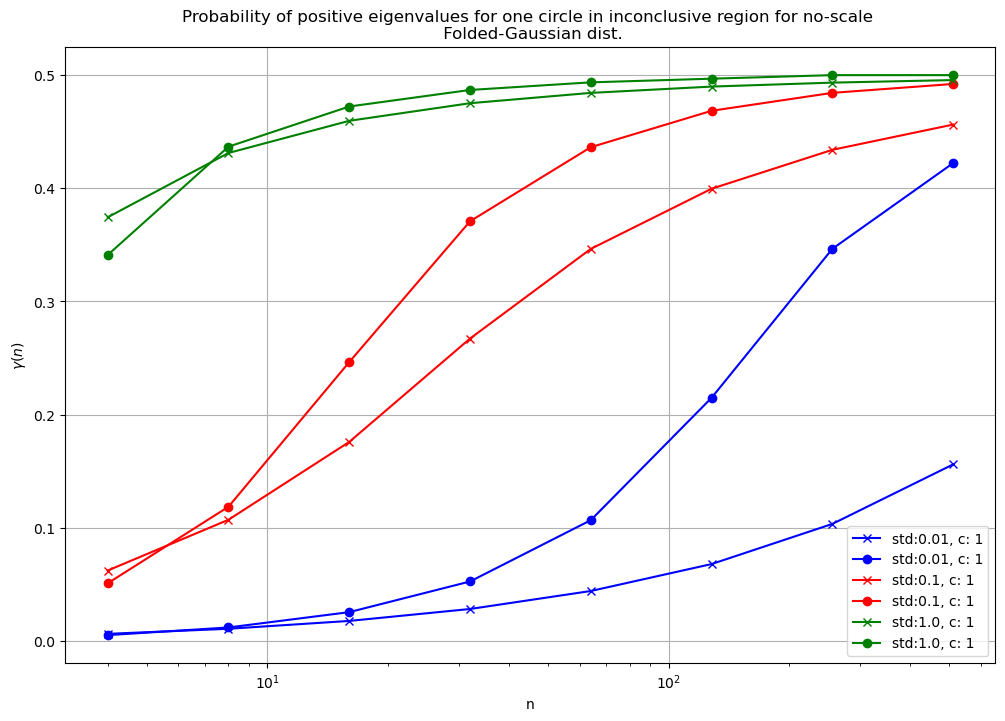

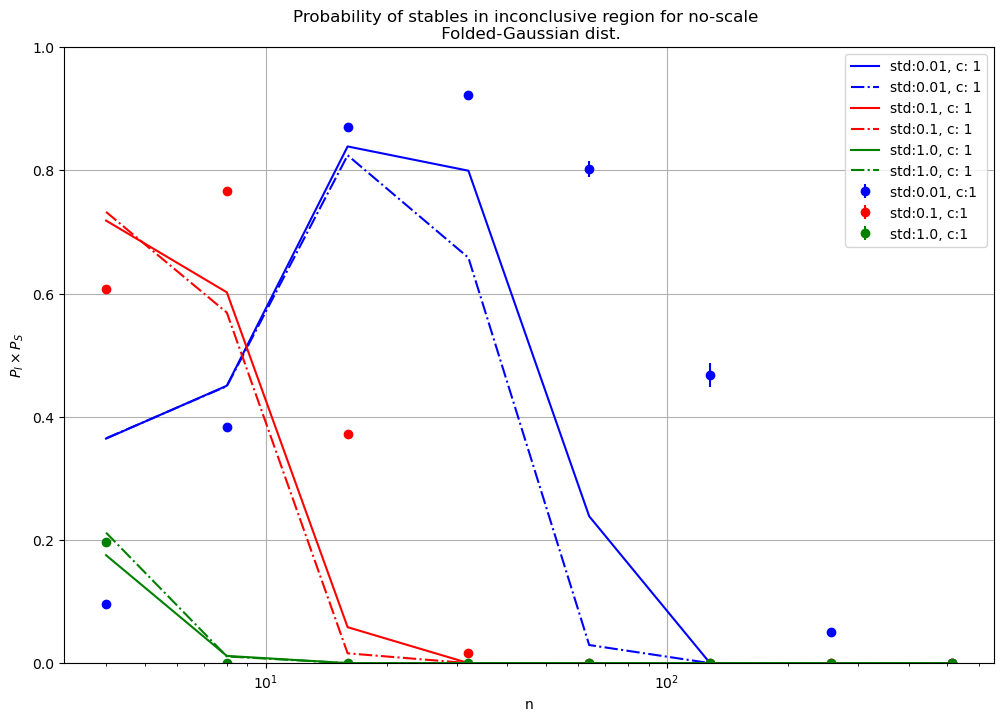

In [563]:
plt.figure(figsize=(12,8))
colors = ['blue', 'red', 'green']
for l,std in enumerate(stds):
    plt.plot(ns,
             alphas_n[l, :], 
             '--',
             c=colors[l%3],
             label=f"std:{std}, c:{c}")
    
    plt.errorbar(ns, mean_super_stable_normal[:, l],
                 yerr=std_super_stable_normal[:, l], 
                 fmt="o",
                 c=colors[l%3],
                 label=f"std:{std}, c:{c}")
    
plt.xscale('log');
plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title("Probability of super-stable region for no-scale \n Folded-Gaussian dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(12,8))

for l,std in enumerate(stds):
    plt.plot(ns,
             gammas[ l, :], 
             '-x',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )    
    
    plt.plot(ns,
             gammas2[ l, :], 
             '-o',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )    


plt.xlabel("n");plt.ylabel(r"$\gamma(n)$");plt.title("Probability of positive eigenvalues for one circle in inconclusive region for no-scale \n Folded-Gaussian dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()
    
    
plt.figure(figsize=(12,8))

for l,std in enumerate(stds):
    plt.plot(ns,
             (1 - gammas[ l, :]*(1-alphas[l]))**ns - alphas[l]**ns, 
             '-',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )
    
    plt.plot(ns,
             (1 - gammas2[ l, :]*(1-alphas[l]))**ns - alphas[l]**ns, 
             '-.',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )

    plt.errorbar(ns, mean_inc_stable_normal[:, l],
                 yerr=std_inc_stable_normal[:, l],
                 fmt="o",
                 c=colors[l%3],
                 label=f"std:{std}, c:{c}")

plt.ylim([0,1])
plt.xlabel("n");plt.ylabel(r"$P_I \times P_S$");plt.title("Probability of stables in inconclusive region for no-scale \n Folded-Gaussian dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

In [548]:
repeats = 5
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
c = 10
lambs = np.array([ c/2, c, 2*c])
res4 = np.load("P_I_P_S_1.npy")
stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
stats_inc_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res4[index][1]
            stats_inc_stable[j, k, t ] =   res4[index][2]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)
mean_inc_stable = np.mean(stats_inc_stable, axis=2)
std_inc_stable = np.std(stats_inc_stable, axis=2)


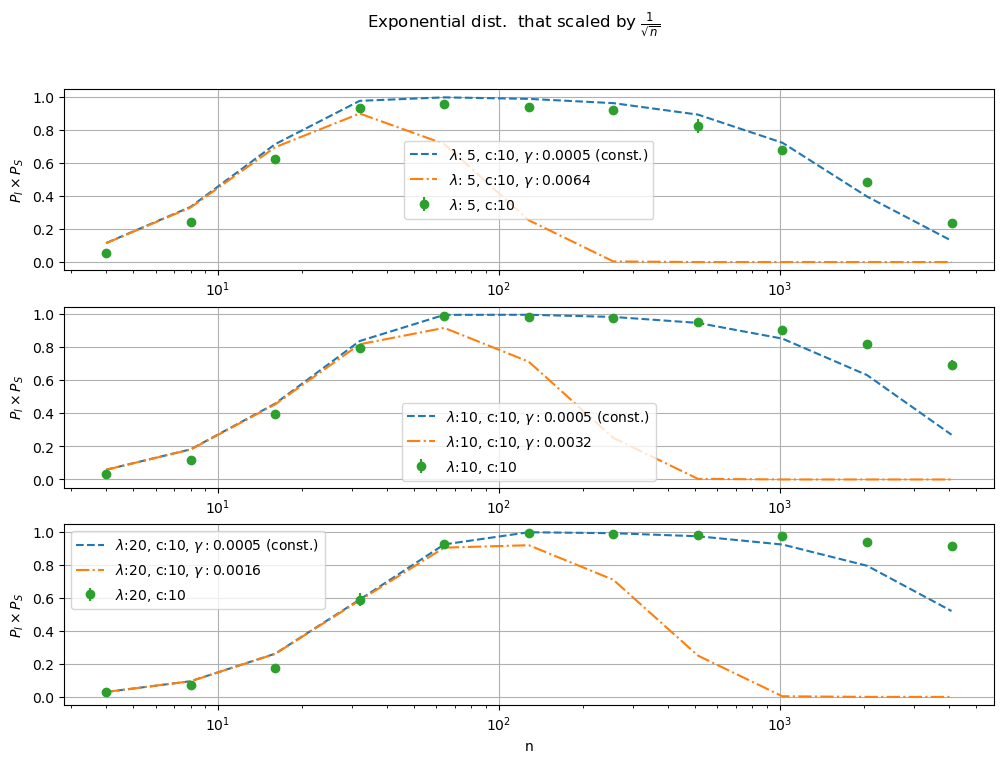

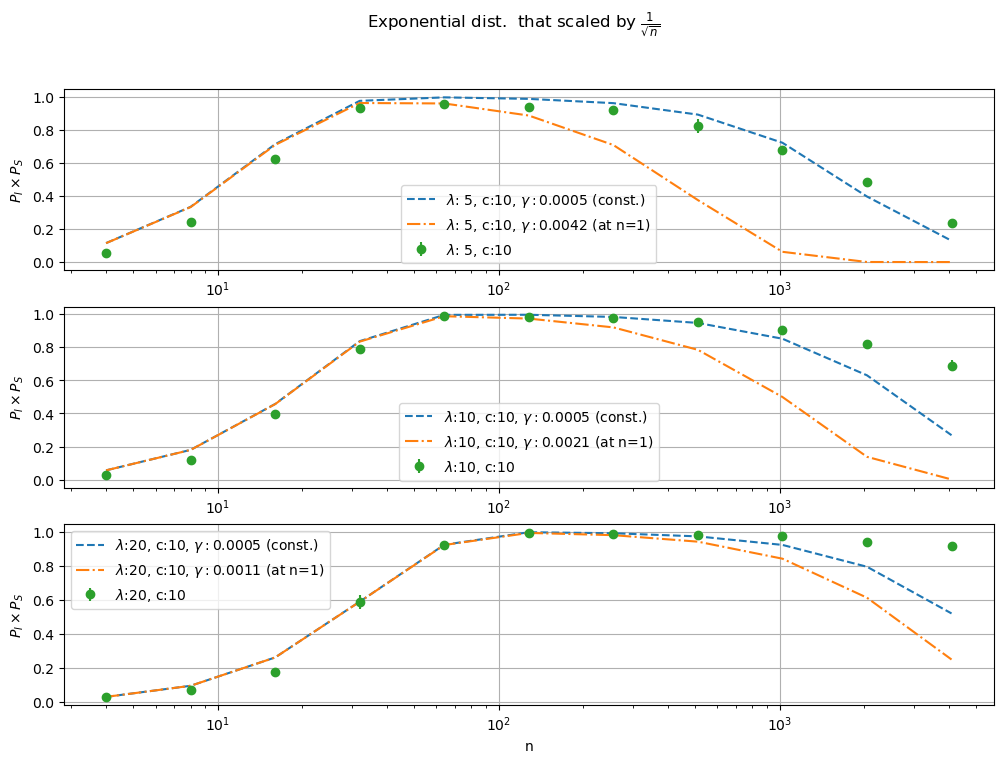

In [549]:
dists = np.array([[create_Erlang_dist(lamb*np.sqrt(n), n-1)
                  for n in ns]
                  for lamb in lambs ])
alphas = np.array([[alpha(c, dist) 
                    for dist in dists[i, :]]
                    for i in range(dists.shape[0])
                  ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

#gamma = 0.0001
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n-1) for n in ns] for lamb in lambs])
gammas_at_one = np.array([psn3(c, lamb*np.sqrt(1), 1) for lamb in lambs])
plt.figure(figsize=(12,8))
plt.title("Probability of stable matricies in inconclusive \n" r"region for scaled $\lambda \sqrt{n}$")    
for k,lamb in enumerate(lambs): 
    if k == 0:
        plt.subplot(311)
    elif k == 1:
        plt.subplot(312)
    else:
        plt.subplot(313)
    plt.plot(ns,
             (1 - gamma*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '--',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gamma} (const.)")
    
    plt.plot(ns,
             (1 - gammas_2[k, :]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-.',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gammas_2[k, 0]:0.4f}")
    
    plt.errorbar(ns, mean_inc_stable[:, k],
                 yerr=std_inc_stable[:, k],
                 fmt="o",
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    plt.legend();plt.grid();plt.xscale('log');plt.ylabel(r"$P_I \times P_S$");

plt.xlabel("n");
plt.suptitle(r"Exponential dist.  that scaled by $\frac{1}{\sqrt{n}}$")
plt.show()

plt.figure(figsize=(12,8))
plt.title("Probability of stable matricies in inconclusive \n" r"region for scaled $\lambda \sqrt{n}$")    
for k,lamb in enumerate(lambs): 
    if k == 0:
        plt.subplot(311)
    elif k == 1:
        plt.subplot(312)
    else:
        plt.subplot(313)
    plt.plot(ns,
             (1 - gamma*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '--',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gamma} (const.)")
    
    plt.plot(ns,
             (1 - gammas_at_one[k]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-.',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gammas_at_one[k]:0.4f} (at n=1)")
    
    plt.errorbar(ns, mean_inc_stable[:, k],
                 yerr=std_inc_stable[:, k],
                 fmt="o",
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    plt.legend();plt.grid();plt.xscale('log');plt.ylabel(r"$P_I \times P_S$");

plt.xlabel("n");
plt.suptitle(r"Exponential dist.  that scaled by $\frac{1}{\sqrt{n}}$")
plt.show()



In [259]:
ns = 2**np.arange(2, 11)
ns = np.linspace(630, 640, 11).astype(np.int16)
c = 1
lambs = np.array([  c*50,  1000*c])
gammas = np.array([[ psn3(c, lamb, n) for n in ns] for lamb in lambs])

/tmp/ipykernel_49640/4188656420.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func,


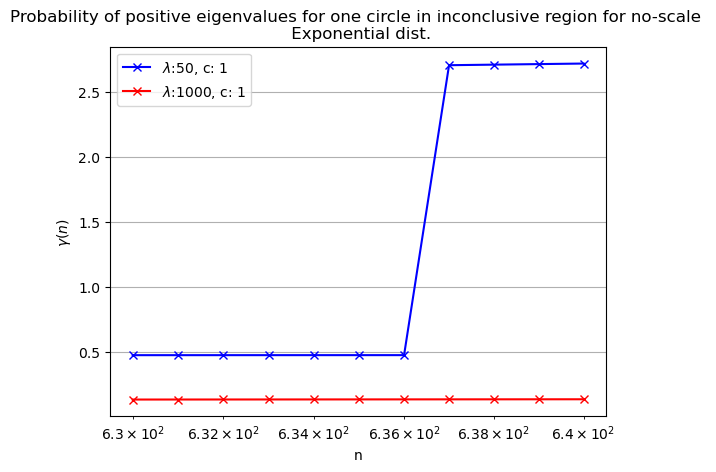

In [159]:
for k,lamb in enumerate(lambs):
    plt.plot(ns,
             gammas[k, :], 
             '-x',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}" )    

plt.xlabel("n");plt.ylabel(r"$\gamma(n)$");plt.title("Probability of positive eigenvalues for one circle in inconclusive region for no-scale \n Exponential dist.")    
plt.legend();plt.grid();plt.xscale('log');plt.show()


In [340]:
ns = np.logspace(.01,2)#np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])
c = 1
stds = np.array([ 0.01, 0.1, 1])
mean = 0.01*np.sqrt(2/np.pi)
alphas = np.array([[alpha_clt(c, mean, std, n-1) 
                             for n in ns]
                             for std in stds])

dists = np.array([[create_normal_dist((n-1)*mean, 
                                      np.sqrt(n-1)*std) 
                     for n in ns]
                     for std in stds])
gammas2 = np.array([[gamma_with_laplace(c,(n-1),mean ,dist) 
                     for dist, n in zip(dists[i, :], ns)]
                      for i in range(dists.shape[0])])

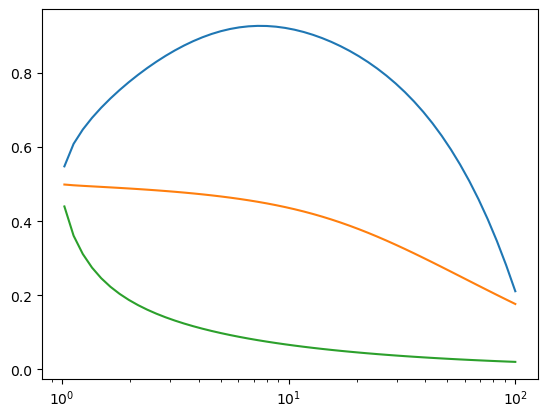

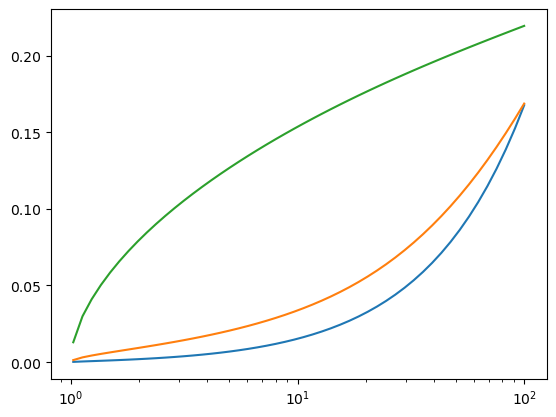

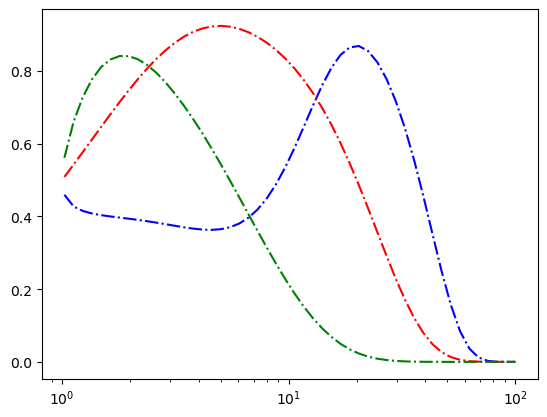

In [341]:
plt.plot(ns, alphas.T); plt.xscale('log');plt.show()
plt.plot(ns, gammas2.T); plt.xscale('log');plt.show()
for l,std in enumerate(stds):
    plt.plot(ns,
             (1 - gammas2[ l, :]*(1-alphas[l]))**ns - alphas[l]**ns, 
             '-.',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )
    
plt.xscale('log');plt.show()    

In [680]:
c = 150
n = 100
mu= 1
std=10

def q1(r, mean, std):
    return (mean/2)*erf((r-mean)/np.sqrt(2*std*std)) - (std/np.sqrt(2*np.pi))*np.exp(-(r-mean)**2/(2*std*std))

def g(r,c):
    return (.5 
            + (2*r/(3*c*pi)) 
            - (r/(c*pi))*power(1- (c/r)**2, 1/2)
            + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
            - (arcsin(c/r)/pi))
in1, err1= integrate.quad(lambda r: g(r,c)*np.exp(-(r-n*mu)**2/(2*n*std*std)),
                          c, np.inf)

in2, err2= integrate.quad(lambda r: 2/(3*pi)*np.exp(-(r-n*mu)**2/(2*n*std*std)),
                          c, np.inf)

(in1/np.sqrt(2*n*std*std),# err1, 
 in2/np.sqrt(2*n*std*std),# err2,
 #(c,n*mu,c<n*mu), 
 #(1/2)*(1-erf((c-n*mu)/np.sqrt(2*n*std*std))),
(2/(3*pi))*(1-erf((c-n*mu)/np.sqrt(2*n*std*std))))

(0.15234177074150818, 0.1160491103217762, 0.13094739844706108)

In [778]:
c=15
n=10
lamb=1
mu = 1/lamb
std=np.sqrt(1/lamb)
print(c, n*mu, c>n*mu)

dist_func = create_Erlang_dist(lamb=lamb, k=n)
gamma(c,dist_func), ((2/(3*pi*c))*(q1(c, n/lamb, np.sqrt(n/lamb)) -q1(-c, n/lamb, np.sqrt(n/lamb)))
                     + (2/(3*pi))*(1-erf((c-n*mu)/np.sqrt(2*n*std*std))+1-erf((c+n*mu)/np.sqrt(2*n*std*std)))
),  ((2/(3*pi*c))*(q1(c, n/lamb, np.sqrt(n/lamb)) -q1(-c, n/lamb, np.sqrt(n/lamb))) 
                     + g(n/lamb,c)
   )

15 10.0 True


/tmp/ipykernel_49640/632662079.py:12: RuntimeWarning: invalid value encountered in power
  - (r/(c*pi))*power(1- (c/r)**2, 1/2)
/tmp/ipykernel_49640/632662079.py:13: RuntimeWarning: invalid value encountered in power
  + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
/tmp/ipykernel_49640/632662079.py:14: RuntimeWarning: invalid value encountered in arcsin
  - (arcsin(c/r)/pi))


(0.14128609035535725, 0.1626904147524222, nan)

In [692]:
(4/(3*pi*c))*q1(c, n/lamb, np.sqrt(n/lamb)) , 2*g(n/lamb,c)

(-19.291508253563073, 0.9929972531165601)

In [604]:
(n/lamb)*.5*erf((n*mu-c)/np.sqrt(2*n*std*std))

50.0